In [63]:
%%capture
!pip3 install nltk
!pip3 install nltk
!pip3 install plotly
!pip3 install gensim
!pip3 install python-Levenshtein

In [64]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, recall_score
import pandas as pd
import html
from wordcloud import WordCloud
import nltk
import re
from IPython.display import Markdown, display
from gensim import utils
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import numpy
from random import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SV

csv_file = open('sms_collection.csv', 'r')
lines = csv_file.readlines()

VALID_LABELS = ["spam", "ham"]

dataframe_cols = ["IsSpam", "MessageText"]
sms_data = pd.DataFrame(columns = dataframe_cols)

is_header = True
for line in lines:
    # skip the first line
    if is_header:
        is_header = False
        continue

    parts = line.split(";")
    label = parts[0]
    
    if label not in VALID_LABELS:
        exit("Unknown label supplied for SMS data")

    sms_text = html.unescape(";".join(parts[1:]))
    sms_text.rstrip()
    sms_text.lstrip()

    is_spam = int(label == "spam")

    row = pd.DataFrame([[is_spam, sms_text]], columns = ["IsSpam", "MessageText"])
    sms_data = sms_data.append(row)

In [65]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    sms_data,
    sms_data['IsSpam'],
    test_size = 0.2
)

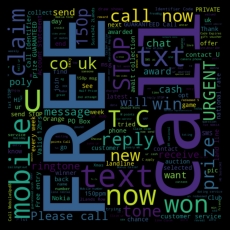

In [66]:
spam_contents = " ".join(list(sms_data.loc[sms_data['IsSpam'] == 1]['MessageText']))
spam_wordcloud = WordCloud(width = 512, height = 512).generate(spam_contents)
plt.figure(figsize = (3, 3), facecolor = "k")
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

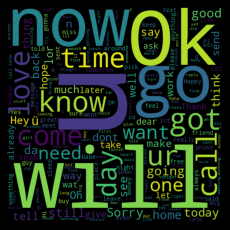

In [68]:
ham_contents = " ".join(list(sms_data.loc[sms_data['IsSpam'] == 0]['MessageText']))
ham_wordcloud = WordCloud(width = 512, height = 512).generate(ham_contents)
plt.figure(figsize = (3, 3), facecolor = "k")
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [69]:
total_observations = len(sms_data.index)
print("Dataset Size: {}".format(total_observations))
print(sms_data['IsSpam'].value_counts())
print(sms_data['IsSpam'].value_counts() / len(sms_data.index) * 100.0)

Dataset Size: 5574
0    4827
1     747
Name: IsSpam, dtype: int64
0    86.598493
1    13.401507
Name: IsSpam, dtype: float64


In [87]:
def tokenize_text(text):
    tokens = []

    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue

            tokens.append(word.lower())

    return tokens

In [125]:
X_train_tagged = X_train.apply(lambda sms: TaggedDocument(words=tokenize_text(sms['MessageText']), tags=[sms.IsSpam]), axis=1)
X_test_tagged = X_test.apply(lambda sms: TaggedDocument(words=tokenize_text(sms['MessageText']), tags=[sms.IsSpam]), axis=1)

In [126]:
# build a doc2vec model with the tagged values from the training set
doc2vec_model = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
doc2vec_model.build_vocab([x for x in X_train_tagged.values])

epoch_count = 50
for epoch in range(50):
    doc2vec_model.train(sklearn.utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
    doc2vec_model.alpha -= 0.002
    doc2vec_model.min_aplha = doc2vec_model.alpha

In [182]:
def vectorize(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps = 20)) for doc in sents])

    return targets, regressors

def show_metrics(description, Y_expected, Y_predicted):
    display(Markdown(f"**{description}**"))
    print('Accuracy %s' % accuracy_score(Y_expected, Y_predicted))
    print('Recall %s' % recall_score(Y_expected, Y_predicted))
    print('F1 score: {}'.format(f1_score(Y_expected, Y_predicted, average='weighted')))

In [171]:
Y_train_final, X_train_final = vectorize(doc2vec_model, X_train_tagged)
Y_test_final, X_test_final = vectorize(doc2vec_model, X_test_tagged)

In [184]:
# train our logistic regression model and fit the training data
logistic_regression = LogisticRegression(max_iter = 100000)
logistic_regression.fit(X_train_final, Y_train_final)

Y_predicted_log_reg = logistic_regression.predict(X_test_final)
show_metrics('Logistic Regression Performance Metrics:', Y_test_final, Y_predicted_log_reg)

**Logistic Regression Performance Metrics:**

Accuracy 0.8887892376681614
Recall 0.3333333333333333
F1 score: 0.8699607720803276


In [185]:
# train our logistic regression model and fit the training data
svm = SVC(max_iter = 100000)
svm.fit(X_train_final, Y_train_final)

Y_predicted_log_reg = svm.predict(X_test_final)
show_metrics('SVM Performance Metrics:', Y_test_final, Y_predicted_log_reg)

**SVM Performance Metrics:**

Accuracy 0.9004484304932735
Recall 0.4528301886792453
F1 score: 0.8897386681981642
